In [20]:
import os
from os import walk
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim

In [21]:
# check if files can be opened
print(os.listdir("./"))

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


['.DS_Store', 'test_v1.pth', 'data_32', 'data_256', 'README.md', '.gitignore', '351.ipynb', '.ipynb_checkpoints', '.git']
PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [22]:
calc_transform = transforms.Compose([transforms.ToTensor()])
calc_dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=calc_transform)

calc_loader = torch.utils.data.DataLoader(calc_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
# Only need to preprocess once
# here are the results
# mean: tensor([0.5162, 0.4644, 0.3975])
# std:  tensor([0.2728, 0.2641, 0.2575])

def get_mean_std(loader):
    chan_sum, chan_sq_sum, num_batch = 0, 0, 0
    for data, _ in tqdm(loader):
        chan_sum += torch.mean(data, dim=[0,2,3])
        chan_sq_sum += torch.mean(data**2, dim=[0,2,3])
        num_batch += 1
    mean = chan_sum/num_batch
    std = (chan_sq_sum/num_batch - mean**2) ** 0.5
    return mean, std

mean, std = get_mean_std(calc_loader)
print('mean: '  + str(mean))
print('std:  '  + str(std))

100%|███████████████████████████████████████| 1563/1563 [00:58<00:00, 26.87it/s]

mean: tensor([0.5163, 0.4644, 0.3975])
std:  tensor([0.2728, 0.2641, 0.2575])


In [23]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5162, 0.4644, 0.3975], 
                                                     [0.2728, 0.2641, 0.2575])])
dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                         shuffle=True, num_workers=2)

In [24]:
labels_map = {
    0: "art_nouveau",
    1: "baroque",
    2: "expressionism",
    3: "impressionism",
    4: "post_impressionism",
    5: "realism",
    6: "renaissance",
    7: "romanticism",
    8: "surrealism",
    9: "ukiyo_e",
}

In [25]:
# Get one batch
images, labels = next(iter(dataloader))
images1, labels1 = next(iter(calc_loader))
print(images[1].size())

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


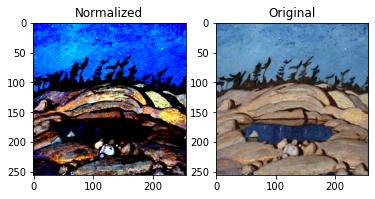

In [27]:
# see some pictures
some_index = 7

fig, axs = plt.subplots(1,2)
plt.title(labels_map[labels[some_index].item()])
axs[0].set_title('Normalized')
axs[1].set_title('Original')
axs[0].imshow(images[some_index].permute(1,2,0))
axs[1].imshow(images1[some_index].permute(1,2,0))


## Notes about Conv2d

<br>

### Parameters:
* in_channels (int) <br>
    * Number of channels in the input image<br>
* out_channels (int) <br>
    * Number of channels produced by the convolution<br>
* kernel_size (int or tuple)<br>
    * Size of the convolving kernel<br><br>

* stride (int or tuple, optional) <br>
    * Stride of the convolution. Default: 1<br>
* padding (int or tuple, optional) <br>
    * Zero-padding added to both sides of the input. Default: 0<br>
* padding_mode (string, optional) <br>
    * ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’<br>
* dilation (int or tuple, optional) <br>
    * Spacing between kernel elements. Default: 1<br>
* groups (int, optional) <br>
    * Number of blocked connections from input channels to output channels. Default: 1<br>
* bias (bool, optional) <br>
    * If True, adds a learnable bias to the output. Default: True<br>

<br>

### Output Size:  
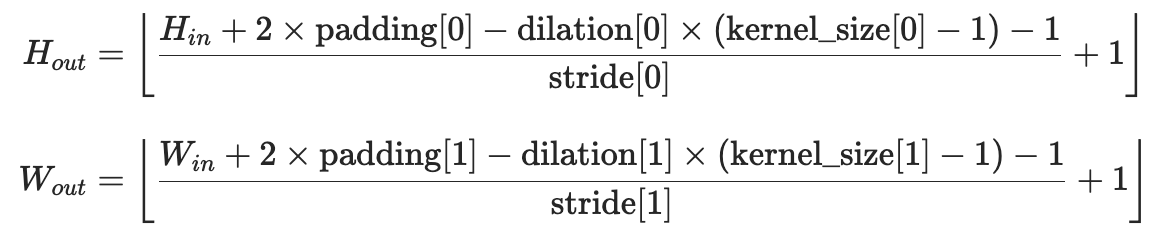



In [5]:
# implementation of VGG-BN for 3*256*256 inputs
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Conv2d
        #in_channels (int) – Number of channels in the input image
        #out_channels (int) – Number of channels produced by the convolution
        #kernel_size (int or tuple) – Size of the convolving kernel
        
        #output size of conv2d
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False))
        
        self.layer4 = nn.AdaptiveAvgPool2d(output_size=(5,5))
        
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=3200, out_features = 1024, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=1024, out_features = 256, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.layer7 = nn.Linear(in_features=256, out_features = 10, bias = True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, 1)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x

net = Net()

In [18]:
summary(net, input_size = (32, 3, 256, 256))

/Users/zijunning/opt/anaconda3/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/zijunning/opt/anaconda3/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 256, 256]        128
│    └─ReLU: 2-3                         [32, 64, 256, 256]        --
│    └─MaxPool2d: 2-4                    [32, 64, 128, 128]        --
├─Sequential: 1-2                        [32, 128, 63, 63]         --
│    └─Conv2d: 2-5                       [32, 128, 126, 126]       73,856
│    └─BatchNorm2d: 2-6                  [32, 128, 126, 126]       256
│    └─ReLU: 2-7                         [32, 128, 126, 126]       --
│    └─MaxPool2d: 2-8                    [32, 128, 63, 63]         --
├─Sequential: 1-3                        [32, 128, 30, 30]         --
│    └─Conv2d: 2-9                       [32, 128, 61, 61]         147,584
│

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
num_epoch = 30;
total_step = len(dataloader);

for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch+1, num_epoch))
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, labels = data

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # back prop
        loss.backward()
        optimizer.step()
#         print(preds)
#         print(labels)
        # stats
        running_loss += loss.item()*inputs.size(0)
        running_correct += torch.sum(preds == labels)
        
        print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
             .format(epoch+1, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*32))
        
#         if(i % 300  == 1):
#             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Running Loss: {:.4f}' 
#                    .format(epoch+1, num_epoch, i+1, total_step, loss.item(), running_loss))
        
    # TODO: VALIDATION SET? IN EACH EPOCH

print('Finished Training')

  0%|                                                    | 0/30 [00:00<?, ?it/s]

------ Starting Epoch [1/30] ------



0it [00:00, ?it/s]
1it [00:06,  6.47s/it]

Epoch [1/30], Step [1/1563], Running Loss: 142.0942, running Correct: [2/32]



2it [00:11,  5.61s/it]

Epoch [1/30], Step [2/1563], Running Loss: 249.8817, running Correct: [2/64]



3it [00:16,  5.32s/it]

Epoch [1/30], Step [3/1563], Running Loss: 338.9818, running Correct: [3/96]



4it [00:21,  5.21s/it]

Epoch [1/30], Step [4/1563], Running Loss: 421.4692, running Correct: [3/128]



5it [00:26,  5.10s/it]

Epoch [1/30], Step [5/1563], Running Loss: 495.2576, running Correct: [8/160]



6it [00:31,  5.23s/it]

Epoch [1/30], Step [6/1563], Running Loss: 570.6209, running Correct: [8/192]



7it [00:36,  5.15s/it]

Epoch [1/30], Step [7/1563], Running Loss: 643.7695, running Correct: [12/224]



8it [00:41,  5.11s/it]

Epoch [1/30], Step [8/1563], Running Loss: 717.5438, running Correct: [14/256]



9it [00:47,  5.12s/it]

Epoch [1/30], Step [9/1563], Running Loss: 791.2622, running Correct: [18/288]



10it [00:52,  5.24s/it]

Epoch [1/30], Step [10/1563], Running Loss: 865.1234, running Correct: [20/320]



11it [00:57,  5.26s/it]

Epoch [1/30], Step [11/1563], Running Loss: 939.3931, running Correct: [21/352]



12it [01:03,  5.31s/it]

Epoch [1/30], Step [12/1563], Running Loss: 1013.0053, running Correct: [24/384]



13it [01:08,  5.26s/it]

Epoch [1/30], Step [13/1563], Running Loss: 1086.6945, running Correct: [29/416]



14it [01:13,  5.28s/it]

Epoch [1/30], Step [14/1563], Running Loss: 1160.1530, running Correct: [33/448]



15it [01:19,  5.31s/it]

Epoch [1/30], Step [15/1563], Running Loss: 1234.1969, running Correct: [35/480]



16it [01:24,  5.27s/it]

Epoch [1/30], Step [16/1563], Running Loss: 1308.8283, running Correct: [35/512]



17it [01:29,  5.23s/it]

Epoch [1/30], Step [17/1563], Running Loss: 1382.2010, running Correct: [38/544]



18it [01:34,  5.24s/it]

Epoch [1/30], Step [18/1563], Running Loss: 1456.1589, running Correct: [41/576]



19it [01:40,  5.27s/it]

Epoch [1/30], Step [19/1563], Running Loss: 1530.1769, running Correct: [42/608]



20it [01:45,  5.24s/it]

Epoch [1/30], Step [20/1563], Running Loss: 1603.6158, running Correct: [48/640]



21it [01:50,  5.23s/it]

Epoch [1/30], Step [21/1563], Running Loss: 1677.0959, running Correct: [51/672]



22it [01:56,  5.34s/it]

Epoch [1/30], Step [22/1563], Running Loss: 1751.0536, running Correct: [54/704]



23it [02:01,  5.32s/it]

Epoch [1/30], Step [23/1563], Running Loss: 1824.4519, running Correct: [58/736]



24it [02:06,  5.35s/it]

Epoch [1/30], Step [24/1563], Running Loss: 1897.7863, running Correct: [63/768]



25it [02:12,  5.55s/it]

Epoch [1/30], Step [25/1563], Running Loss: 1971.1588, running Correct: [68/800]



26it [02:18,  5.56s/it]

Epoch [1/30], Step [26/1563], Running Loss: 2044.7427, running Correct: [71/832]


26it [02:24,  5.54s/it]
  0%|                                                    | 0/30 [02:38<?, ?it/s]


KeyboardInterrupt: 

In [29]:
PATH = './test_v1.pth'
torch.save(net.state_dict(), PATH)

In [30]:
test_set = datasets.ImageFolder("/Users/zijunning/Documents/EECS_351/data_256/art_pictures/test",
                               transform=transform)
testloader = torch.utils.data.DataLoader(dataset, shuffle=True)

In [32]:
dataiter = iter(testloader)

In [39]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        test_images, test_labels = data
        # calculate outputs by running images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %
